# Chicago Crime Data API Pull and Exploration

In [1]:
from util import api_util
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api_util.get_socrata_app_token()

'FgSIlio2ikkxrA8YFFblYJDcc'

In [3]:
class SocrataAPIClient:
    """
    Class for making requests to Socrata Chicago API
    and parsing, updating the response object
    """

    def __init__(self, request_url):

        self.request_url = None
        self.params = self._get_app_token_params()
        self.response = None
        self.data_df = None

        # for reviewing datatypes
        self.header_fields = None
        self.header_dtypes = None

        self._get_request(request_url)

    @staticmethod
    def _get_app_token_params():
        """
        gets api token and formats the params dict for request
        :return: dict containing app token
        """
        token = api_util.get_socrata_app_token()
        return {"$$app_token": token}

    def _get_request(self, request_url):
        """
        sends get request to socrata api
        parses reponse header for debugging data types
        converse json response to a pandas DataFrame
        updates the data types in data_df, the pandas DataFrame containing the
        API response data

        Attempt to convert all fields to numeric types (float or integer)
        Then convert non numeric types back to string

        :param request_url: url for the get request
        :return: NA
        """
        # For header codes included in response object: 
        # https://dev.socrata.com/docs/response-codes.html

        # Difference between a Request and a Response object:
        # https://requests.readthedocs.io/en/master/user/advanced/#request-and-response-objects
        # get and parse response
        self.response = requests.get(request_url, self.params)
        self.request_url = self.response.request.url
        if self.response.status_code != 200:
            raise Exception(f"bad request: {self.request_url}")

        self.header_fields = self.response.headers['X-SODA2-Fields']
        self.header_dtypes = self.response.headers['X-SODA2-Types']

        # convert to pandas df
        self.data_df = pd.DataFrame.from_dict(self.response.json())

In [4]:
class SodaData:
    """
    Data object for managing/storing fields related to a Socrata dataset.

    This class builds a socrata request url using a soql query.
    The request can be made via data/socrata_api_requests

    """

    def __init__(self, dataset_name, sql_table_name, identifier,
                 desired_attr_lst,
                 week_avg_attr_lst=None,
                 group_by=None,
                 where=None,
                 limit=None):
        """
        Constructor for SodaData

            dataset_name: (str) internal/informal name for data set
            sql_table_name: (str) table name in sqlite db
            identifier: (str) socrata ID
            desired_attr_list: list of (str) where each item represents
                a field in the soql select statement
            week_avg_attr_lst: list of (str) that should be a subset of
                desired_attr_list. represents fields on which to compute a weekly avg.
            group_by = (str) name of field to groupby in soql query
            where = (str) where statements for soql query
            limit = (int) number of rows on which to limit soql query
        """

        self.dataset_name = dataset_name
        self.sql_table_name = sql_table_name
        self.identifier = identifier

        # constructing api query
        self.base_url = f"https://data.cityofchicago.org/resource/{identifier}.json"
        self.desired_attr_lst = desired_attr_lst
        self.group_by_lst = group_by
        self.where_lst = where
        self.limit = limit

        # api request url
        self.request_url = self._build_soql_query()

        # variables for which weekly averages will be computed
        self.COLS_TO_AVG = week_avg_attr_lst

    def _build_soql_query(self):
        """
        builds a soql query to append to base request url.

        :return: (str) socrata api request url
        """

        # soql docs: https://dev.socrata.com/docs/queries/

        query =  f"?$query=SELECT {', '.join(self.desired_attr_lst)}"
        if self.where_lst:
            query += f" WHERE {'AND '.join(self.where_lst)}"
        if self.group_by_lst:
            query += f" GROUP BY {', '.join(self.group_by_lst)}"
        if self.limit:
            query += f" LIMIT {self.limit}"

        return self.base_url + query

In [5]:
TRAFFIC_CRASH_DATA_OBJ_HISTORICAL = SodaData("Traffic Crashes",
                              "TRAFFIC_CRASHES",
                              "85ca-t3if",
                              ["CRASH_RECORD_ID", "CRASH_DATE",
                               "latitude", "longitude"],
                              where=["CRASH_DATE > '2019-01-01T00:00:00'",
                                     "CRASH_DATE < '2021-03-07T00:00:00'"],
                              limit=300000)

#crime data
#'https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2'
CRIME_DATA_2001_ON = SodaData('Chicago Crime',
                             'CHCIAGO_CRIME',
                             'ijzp-q8t2',
                             ["id", "case_number", "date", "iucr",
                             "primary_type", "description", "location_description",
                             "arrest", "domestic", "beat", "ward", "community_area",
                              "latitude", "longitude", "location"],
                             limit=1000)
#NEED TO ADJUST LIMIT TO PULL ALL DATA

In [6]:
CRIME_DATA_2001_ON
print(CRIME_DATA_2001_ON.base_url)


https://data.cityofchicago.org/resource/ijzp-q8t2.json


In [7]:
data_obj = CRIME_DATA_2001_ON  # 1
print(f" ##### making api request and create table for {data_obj.dataset_name} ####")
api_resp = SocrataAPIClient(data_obj.request_url)  # 2

print(f"    request url: {api_resp.request_url}")
print(f"    request headers {api_resp.header_fields}")
print(f"    request header dtypes {api_resp.header_dtypes}")
print("~~~~ pandas df dtypes ~~~~")
print(api_resp.data_df.dtypes)
print("~~~~ sql table info ~~~~~")
print(f"nrow df:{len(api_resp.data_df)}\n")
print(api_resp.data_df.tail())
crime_df = api_resp.data_df

 ##### making api request and create table for Chicago Crime ####
    request url: https://data.cityofchicago.org/resource/ijzp-q8t2.json?$query=SELECT%20id,%20case_number,%20date,%20iucr,%20primary_type,%20description,%20location_description,%20arrest,%20domestic,%20beat,%20ward,%20community_area,%20latitude,%20longitude,%20location%20LIMIT%201000&%24%24app_token=FgSIlio2ikkxrA8YFFblYJDcc
    request headers ["id","case_number","date","iucr","primary_type","description","location_description","arrest","domestic","beat","ward","community_area","latitude","longitude","location"]
    request header dtypes ["number","text","floating_timestamp","text","text","text","text","boolean","boolean","text","number","text","number","number","location"]
~~~~ pandas df dtypes ~~~~
id                      object
case_number             object
date                    object
iucr                    object
primary_type            object
description             object
location_description    object
arrest

In [8]:
crime_df.shape

(1000, 15)

In [9]:
crime_df.head(5)

,id,case_number,date,iucr,primary_type,description,location_description,arrest,domestic,beat,ward,community_area,latitude,longitude,location
0,10224738,HY411648,2015-09-05T13:30:00.000,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,0924,12,61,41.815117282,-87.669999562,"{'latitude': '41.815117282', 'longitude': '-87..."
1,10224739,HY411615,2015-09-04T11:30:00.000,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,29,25,41.895080471,-87.765400451,"{'latitude': '41.895080471', 'longitude': '-87..."
2,11646166,JC213529,2018-09-01T00:01:00.000,0810,THEFT,OVER $500,RESIDENCE,False,True,0631,8,44,NaN,NaN,NaN
3,10224740,HY411595,2015-09-05T12:45:00.000,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,35,21,41.937405765,-87.716649687,"{'latitude': '41.937405765', 'longitude': '-87..."
4,10224741,HY411610,2015-09-05T13:00:00.000,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,28,25,41.881903443,-87.755121152,"{'latitude': '41.881903443', 'longitude': '-87..."


In [10]:
crime_df.columns

Index(['id', 'case_number', 'date', 'iucr', 'primary_type', 'description',
       'location_description', 'arrest', 'domestic', 'beat', 'ward',
       'community_area', 'latitude', 'longitude', 'location'],
      dtype='object')

In [11]:
crime_df['date'] = pd.to_datetime(crime_df['date'])

In [34]:
#extract just the date (not time of day)
crime_df['day_date'] = crime_df['date'].dt.date

In [39]:
crime_df.dtypes

id                              object
case_number                     object
date                    datetime64[ns]
iucr                            object
primary_type                    object
description                     object
location_description            object
arrest                            bool
domestic                          bool
beat                            object
ward                            object
community_area                  object
latitude                        object
longitude                       object
location                        object
day_date                        object
dtype: object

In [13]:
crime_df['date'].max()

Timestamp('2020-03-18 13:00:00')

In [14]:
crime_df['date'].min()

Timestamp('2001-01-01 11:00:00')

In [15]:
def basic_plot(df, x_axis, y_axis, title):
    df.plot()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend()

In [19]:
crime_df.isna().sum()

id                       0
case_number              0
date                     0
iucr                     0
primary_type             0
description              0
location_description     5
arrest                   0
domestic                 0
beat                     0
ward                     0
community_area           0
latitude                55
longitude               55
location                55
dtype: int64

In [26]:
crime_df['beat'].value_counts()

0423    14
1531    14
1522    13
0624    13
0421    12
        ..
1111     1
2513     1
0724     1
2024     1
1813     1
Name: beat, Length: 255, dtype: int64

In [27]:
crime_df['iucr'].value_counts()

0486    114
0820     74
0460     66
0810     59
1320     54
       ... 
0550      1
0337      1
0483      1
2017      1
1570      1
Name: iucr, Length: 122, dtype: int64

In [28]:
crime_df['arrest'].value_counts()

False    709
True     291
Name: arrest, dtype: int64

In [30]:
crime_df['domestic'].value_counts()

False    809
True     191
Name: domestic, dtype: int64

In [32]:
crime_df['community_area'].value_counts()

25    63
28    40
24    36
8     33
69    32
      ..
18     2
62     2
57     1
45     1
76     1
Name: community_area, Length: 73, dtype: int64

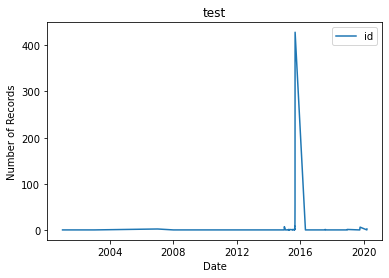

In [42]:
basic_plot(crime_df.groupby('day_date')['id'].count(), 'Date', 'Number of Records', 'test')

In [44]:
crime_df.groupby('day_date')['id'].count().sort_values()

day_date
2001-01-01      1
2015-07-02      1
2015-07-07      1
2015-08-03      1
2015-08-05      1
             ... 
2015-09-01      9
2015-09-03     29
2015-09-04     53
2015-09-05    361
2015-09-06    428
Name: id, Length: 84, dtype: int64